In [1]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
# EarlyStopping : 
# Model Chechpoint : 

from preprocess import * 

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.legend([string], 'val_' + string)

In [3]:
# 데이터 저장

DATA_IN_PATH = 'data_in/'
DATA_OUT_PATH = 'data_out/'

TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'

DATA_CONFIGS = 'data_config.json'

In [4]:
tf.random.set_seed(1234)

In [5]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))

prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
print(len(index_inputs), len(index_outputs), len(index_targets))

120 120 120


In [20]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 10
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

In [8]:
prepro_configs.keys()

dict_keys(['char2idx', 'idx2char', 'vocab_size', 'pad_symbol', 'std_symbol', 'end_symbol', 'unk_symbol'])

In [9]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
unk_index = prepro_configs['unk_symbol']

vocab_size = prepro_configs['vocab_size']

In [10]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()        # 상속 와 이렇게 쓰는거구나...
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True,
                                      recurrent_initializer = 'glorot_uniform')
    
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))
        

In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.W1(values) + self.W2(hidden_with_time_axis) # W1 : value에 관련된.. W2 : 쿼리에 관련된 것
        score = self.V(tf.nn.tanh(score))
        
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights
        

In [12]:
# 오... 층을 아래에서부터 쌓는 것도 좋네
# 그러면 원하는 최종 결과물이 무엇인지를 보고, 그 결과가 나올 수 있게끔 필요한 것들과 양을 더 쉽게 정할 수 있을 듯

class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.batch_sz = batch_sz
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences = True, return_state = True,
                                      recurrent_initializer = 'glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # 오류 : hidden 파라미터 안넣음
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights

In [13]:
# mask를 쓰게 되는데..

import tensorflow as tf

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
# jh 오류 : 단순 오타
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
                                                       
def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    # real -> read 오타
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1)
    pred *= mask
    acc = train_accuracy(real, pred)
    # train_accurach -> train_accuracy 오타
    return tf.reduce_mean(acc)

In [14]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):
        super(seq2seq, self).__init__()
        
        self.end_token_idx = end_token_idx
        
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)
        
    # 어떤 값을 주면, 학습을 진행해라 라는 함수
    def call(self, x):
        inp, tar = x
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        predict_tokens = []
        for t in range(0, tar.shape[1]): # tar.shape[1] -> 한 문장의 길이
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) # float32 로 맞춤
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output) # _ : 출력값은 있으나, 쓰이지 않음
            predictions = tf.dtypes.cast(predictions, tf.float32)
            predict_tokens.append(predictions)
        
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp = x
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1) # STD에 해당하는 index를 반환, 그리고 차원 1개 추가
        
        predict_tokens = []
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0]) # 어떤 단어인지 추려내는 단계 중
            
            if predict_token == self.end_token_idx:
                break # 중지 : predict_token이 end_token의 인덱스와 같아지면
                
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)
        
        
        return tf.stack(predict_tokens, axis = 0).numpy()

In [15]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])

In [21]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not( os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
cp_callback = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True,
                              save_weights_only = True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size = BATCH_SIZE, epochs = EPOCH,
                    validation_split = VALIDATION_SPLIT, callbacks = [earlystop_callback, cp_callback])

Epoch 1/10


2023-01-18 15:08:17.315995: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


54/54 [==============================] - ETA: 0s - loss: 1.8248 - accuracy: 0.8502
Epoch 1: val_accuracy improved from -inf to 0.84927, saving model to data_out/seq2seq_kor/weights.h5
54/54 [==============================] - 36s 527ms/step - loss: 1.8248 - accuracy: 0.8502 - val_loss: 1.6508 - val_accuracy: 0.8493
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 1.1424 - accuracy: 0.8536
Epoch 2: val_accuracy improved from 0.84927 to 0.85033, saving model to data_out/seq2seq_kor/weights.h5
54/54 [==============================] - 26s 481ms/step - loss: 1.1424 - accuracy: 0.8536 - val_loss: 1.3101 - val_accuracy: 0.8503
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 0.8332 - accuracy: 0.8504
Epoch 3: val_accuracy improved from 0.85033 to 0.85089, saving model to data_out/seq2seq_kor/weights.h5
54/54 [==============================] - 26s 473ms/step - loss: 0.8332 - accuracy: 0.8504 - val_loss: 1.3554 - val_accuracy: 0.8509
Epoch 4/10
54/54 [======

In [20]:
################ 이상 : 학습까지 ##################

In [ ]:
# PATH = DATA_OUT_PATH + MODEL_NAME
# if not(os.path.isdir(PATH)):
#     os.makedirs(os.path.join(PATH))
    
# checkpoint_path = DATA_OUT_PATH + MODEL_NAME + 'weights.h5'

# cp_callback = ModelCheckpoint(
#     checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True,
#     save_weights_only = True)

# earlystop_callpack = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 10)

# history = model.fit([index_inputs, index_outputs], index_targets,

/var/folders/fn/b29w84gs71q01kp51x0ty8h80000gn/T/ipykernel_5872/598420532.py:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend([string], 'val_' + string)


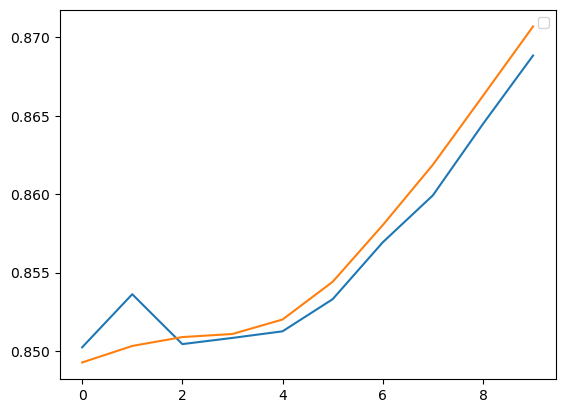

In [22]:
plot_graphs(history, 'accuracy')

/var/folders/fn/b29w84gs71q01kp51x0ty8h80000gn/T/ipykernel_5872/598420532.py:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend([string], 'val_' + string)


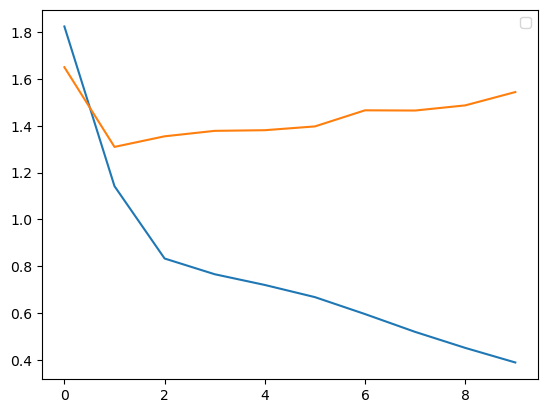

In [23]:
plot_graphs(history, 'loss')

In [24]:
SAVE_FILE_NM = '/weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH + MODEL_NAME + SAVE_FILE_NM))

In [25]:
query = '남자친구 승진 선물로 뭐가 좋을까?'

test_index_inputs, _ = enc_processing([query], char2idx)
predict_tokens = model.inference(test_index_inputs)

print(' '.join([idx2char[t] for t in predict_tokens]))

KeyError: 4294